In [38]:
#import all the necessary packages.
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import numpy as np
import time
import re
import random
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

## Importing the dataset (JSON)

In [39]:
data = pd.read_json('Fashion/tops_fashion.json')

In [40]:
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

In [41]:
data.head(3)

,sku,asin,product_type_name,formatted_price,author,color,brand,publisher,availability,reviews,large_image_url,availability_type,small_image_url,editorial_review,title,model,medium_image_url,manufacturer,editorial_reivew
0,None,B016I2TS4W,SHIRT,None,None,None,FNC7C,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Minions Como Superheroes Ironman Women's O Nec...,Minions Como Superheroes Ironman Long Sleeve R...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
1,None,B01N49AI08,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Izo Tunic,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
2,None,B01JDPCOHO,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Won Top,None,https://images-na.ssl-images-amazon.com/images...,None,NaN


There are a lot of features in the dataset, we will only use 6 of them. So let's filter the columns we will use!



1.   asin (Amazon Standard Identification)
2.   brand
3.   color
4.   Product type
5.   Image
6.   Title
7.   Price



In [42]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]
print('Number of records: ', data.shape[0])
print('Number of features: ', data.shape[1])
data.head(5)

Number of records:  183138
Number of features:  7


,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


### Standard Preprocessing
- Deleting null values
- Remove products with few words in descriptiong
- Remove duplicates

In [43]:
data = data.dropna(subset=['formatted_price', 'color'])
data.shape[0]

28385

In [44]:
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
data_sorted.shape[0]

27949

In [45]:
data_sorted.drop_duplicates()
data_sorted.shape[0]

27949

### Text Preprocessing

We will use the list of stopwords downloaded from the nltk library. 

In [46]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print('list of stop words: ', stop_words)

list of stop words:  {'against', 'further', 'most', 'only', 'why', 'their', 're', "wouldn't", 'than', 'ourselves', 'own', 'wasn', 'he', 'about', 'doesn', 'which', 'just', 'during', 'these', 'himself', 'those', 'whom', 'both', 'yours', 'all', 'm', 'over', 'needn', 'are', 'it', 'under', 'out', 'couldn', 'shouldn', 'being', "wasn't", 'me', 'ain', 'am', "mustn't", 'isn', 'they', 'nor', "you're", 'again', 'were', 'more', 'above', 'been', 'this', 'very', 's', 'no', 'from', 'mightn', "hasn't", 'of', 'didn', 'does', 'weren', 'on', 'at', "you'd", 'there', 'will', 'hadn', 'themselves', 'doing', "needn't", 'hers', "won't", "shouldn't", 'once', 'aren', "haven't", 'yourself', 'll', 'y', 'we', "you'll", 'wouldn', 'myself', 'then', 'her', 'theirs', 'by', 'how', 'with', 'some', 'ours', 'same', 'should', 'any', 'd', 'had', 'she', 'when', 'down', 'because', "should've", "aren't", 'and', 'that', 'haven', 'here', "she's", 'its', 'have', "hadn't", 'herself', 'into', 'for', 'hasn', 'before', 'can', 'as', 'm

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dieter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
def nlp_preprocessing(total_text, index, column):
  if type(total_text) is not int:
    string = ''
    for words in total_text.split():
      word = ("".join(e for e in words if e.isalnum())) # remove special chars in reviews
      word = word.lower() # convert to lower-case
      if not word in stop_words: # stop word removal 
        string += word + " "
    data[column][index] = string

In [48]:
data['formatted_price'] = data['formatted_price'].apply(lambda x: x.replace('$', '')) # remove dollar sign
data.drop(data.loc[data['formatted_price']=='1,129.99'].index, inplace=True)
data.drop(data.loc[data['formatted_price']=="Too low to display"].index, inplace=True)
data['formatted_price'] = data['formatted_price'].astype('float')
data['formatted_price'].describe()

count    28363.000000
mean        32.050132
std         43.411094
min          0.010000
25%         10.800000
50%         19.120000
75%         34.990000
max        995.000000
Name: formatted_price, dtype: float64

In [49]:
data["color"] = data["color"].str.lower()

In [51]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,onyx black/ stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,white,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,9.99
11,B001LOUGE4,Fitness Etc.,black,https://images-na.ssl-images-amazon.com/images...,SHIRT,Ladies Cotton Tank 2x1 Ribbed Tank Top,11.99
15,B003BSRPB0,FeatherLite,white,https://images-na.ssl-images-amazon.com/images...,SHIRT,FeatherLite Ladies' Moisture Free Mesh Sport S...,20.54
21,B014ICEDNA,FNC7C,purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel Short...,7.50


The colors will be reformatted so it's more uniform


In [143]:
#Unity of colors with Regex 
def replace_colors(m):
    colors=["red", "grey","natural","multicol","red orange", "orange", "yellow","yellow green", "green", "sky blue", "blue", "violet", "brown", "black","purple","Berry",'Beige', "white", "gray", "magenta", "pink", "light blue", "aqua green", "jade green", "peach", "golden", 'navy',"yellow", "yellow orange", "mahogany", "tan" , "light brown"]
    match = [re.findall(c, m) for c in colors]
    match = list(filter(None, match))
    match = np.array([item for row in match for item in row])
    if match.size>0:    
        try:
            match = ",".join(match)
        except:
            return match
        finally:
            return match
    else:
        match = random.choice(colors)
        return match

In [144]:
data["color"] = data["color"].map(lambda x: replace_colors(x))

Remove the stopwords with nlp_preprocessing

In [145]:
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')

In [146]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,black,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,white,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,9.99
11,B001LOUGE4,Fitness Etc.,black,https://images-na.ssl-images-amazon.com/images...,SHIRT,ladies cotton tank 2x1 ribbed tank top,11.99
15,B003BSRPB0,FeatherLite,white,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,20.54
21,B014ICEDNA,FNC7C,purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel short sle...,7.50


In [147]:
data.reset_index(inplace=True)
data.head(10)

,index,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,4,B004GSI2OS,FeatherLite,black,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,26.26
1,6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,white,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,9.99
2,11,B001LOUGE4,Fitness Etc.,black,https://images-na.ssl-images-amazon.com/images...,SHIRT,ladies cotton tank 2x1 ribbed tank top,11.99
3,15,B003BSRPB0,FeatherLite,white,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,20.54
4,21,B014ICEDNA,FNC7C,purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel short sle...,7.50
5,27,B014ICEJ1Q,FNC7C,purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,7.39
6,43,B0079BMKDS,FeatherLite,white,https://images-na.ssl-images-amazon.com/images...,APPAREL,featherlite ladies silky smooth pique white xl,13.53
7,46,B01NACPBG2,Fifth Degree,black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,6.95
8,50,B00480IRZS,FineBrandShop,green,https://images-na.ssl-images-amazon.com/images...,SHIRT,ladies green seamless ribbed diamond patterned...,7.90
9,60,B014ICB9A0,FNC7C,black,https://images-na.ssl-images-amazon.com/images...,APPAREL,supernatural chibis sam dean castiel neck shir...,7.39


In [148]:
data.drop("index", axis=1, inplace=True)

In [149]:
data['color'] = data['color'].astype(str)

In [150]:
def convert_remove_duplicate(x):
  x = x.split(",")
  x = list(dict.fromkeys(x))
  x = ",".join(x)
  return x

In [151]:
data["color"] = data["color"].apply(lambda x: convert_remove_duplicate(x))
len(data["color"].unique())

264

In [153]:
pd.set_option("display.max_colwidth", 20)

In [154]:
data.index[data['asin'] == 'B01MYPBEKQ'].tolist()

[26549]

In [155]:
data["medium_image_url"].describe()

count                   28363
unique                  19855
top       https://images-n...
freq                       21
Name: medium_image_url, dtype: object

In [156]:
data.iloc[[16528]]["medium_image_url"][:]

16528    https://images-n...
Name: medium_image_url, dtype: object

In [157]:
data.drop([9132, 11131,4629,12074, 13908,13373,5549,4060,13579,15783,16517],axis=0,inplace=True)

In [158]:
data.drop_duplicates(subset='medium_image_url', keep="last", inplace=True)

In [159]:
data = data[data['brand'].notna()]
data.reset_index(inplace=True)

In [161]:
data.to_csv('Fashion/tops_fashion_final.csv')

In [162]:
df = pd.read_csv('Fashion/tops_fashion_final.csv')

In [163]:
df.drop(["Unnamed: 0"],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19790 entries, 0 to 19789
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              19790 non-null  int64  
 1   asin               19790 non-null  object 
 2   brand              19790 non-null  object 
 3   color              19790 non-null  object 
 4   medium_image_url   19790 non-null  object 
 5   product_type_name  19790 non-null  object 
 6   title              19790 non-null  object 
 7   formatted_price    19790 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 1.2+ MB


In [164]:
df

,index,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,7,B01NACPBG2,Fifth Degree,black,https://images-n...,SHIRT,fifth degree wom...,6.95
1,8,B00480IRZS,FineBrandShop,green,https://images-n...,SHIRT,ladies green sea...,7.90
2,10,B011YPK0MW,Feel The Piece,navy,https://images-n...,SHIRT,feel piece sami ...,72.40
3,13,B0079QXJ3S,FineBrandShop,light blue,https://images-n...,SHIRT,ladies fuchsia p...,7.50
4,14,B01NH5DUH1,Fjällräven,gray,https://images-n...,SHIRT,fjallraven wome...,88.00
...,...,...,...,...,...,...,...,...
19785,28358,B073YGRLSM,Sky and Sparrow,natural,https://images-n...,SHIRT,sky sparrow grom...,26.99
19786,28359,B01NCO06S0,Faded Glory,"grey,blue",https://images-n...,SHIRT,faded glory wome...,18.99
19787,28360,B01AVN150E,Sacred Threads,grey,https://images-n...,SHIRT,printed top asso...,22.00
19788,28361,B01MSALTSO,TOOGOO(R),black,https://images-n...,OUTERWEAR,toogoor womens t...,14.58


In [165]:
df = df.rename(columns={'index':'id'})
df

,id,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,7,B01NACPBG2,Fifth Degree,black,https://images-n...,SHIRT,fifth degree wom...,6.95
1,8,B00480IRZS,FineBrandShop,green,https://images-n...,SHIRT,ladies green sea...,7.90
2,10,B011YPK0MW,Feel The Piece,navy,https://images-n...,SHIRT,feel piece sami ...,72.40
3,13,B0079QXJ3S,FineBrandShop,light blue,https://images-n...,SHIRT,ladies fuchsia p...,7.50
4,14,B01NH5DUH1,Fjällräven,gray,https://images-n...,SHIRT,fjallraven wome...,88.00
...,...,...,...,...,...,...,...,...
19785,28358,B073YGRLSM,Sky and Sparrow,natural,https://images-n...,SHIRT,sky sparrow grom...,26.99
19786,28359,B01NCO06S0,Faded Glory,"grey,blue",https://images-n...,SHIRT,faded glory wome...,18.99
19787,28360,B01AVN150E,Sacred Threads,grey,https://images-n...,SHIRT,printed top asso...,22.00
19788,28361,B01MSALTSO,TOOGOO(R),black,https://images-n...,OUTERWEAR,toogoor womens t...,14.58


Some additional utility functions we will use: 

In [167]:
import requests
from PIL import Image
def display_img(url, ax, fig):
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  plt.imshow(img)

In [168]:
def plot_heatmap(keys, values, labels, url, text):
  # keys: list of words of recommended title
  # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
  # labels: len(labels) == len(keys), the values of labels depends on the model we are using
            # if model == 'bag of words': labels(i) = values(i)
            # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
            # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
  # url : apparel's url
  # we will devide the whole figure into two parts
  gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
  fig = plt.figure(figsize=(25,3))
       
  # 1st, ploting heat map that represents the count of commonly ocurred words in title2
  ax = plt.subplot(gs[0])
  # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
  ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
  ax.set_xticklabels(keys) # set that axis labels as the words of title
  ax.set_title(text) # apparel title
        
  # 2nd, plotting image of the the apparel
  ax = plt.subplot(gs[1])
  # we don't want any grid lines for image and no labels on x-axis and y-axis
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])
        
  # we call dispaly_img based with paramete url
  display_img(url, ax, fig)
        
  # displays combine figure ( heat map and image together)
  plt.show()

In [169]:
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):
    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf
    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 
    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0
    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    plot_heatmap(keys, values, labels, url, text)

In [170]:
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' 
    #this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, 
    #it returns dict type object {word1:count}

In [171]:
def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)
    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)
    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

In [172]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.stem.snowball import SnowballStemmer
import nltk
stemmer = SnowballStemmer("english")

In [173]:
def clean_tokenize(document):
  document = re.sub('[^\w_\s-]', ' ',document) #remove punctuation
  tokens = nltk.word_tokenize(document) #tokenize sentences
  cleaned_article = ' '.join([stemmer.stem(item) for item in tokens]) #stem each token
  return cleaned_article

##BOW model on Product titles and color

In [174]:
title_vectorizer = CountVectorizer()
color_features = title_vectorizer.fit_transform(df['color'])
title_features = title_vectorizer.fit_transform(df['title'])

In [175]:
title_features.get_shape() # get number of rows and columns in feature matrix
bag_of_words_euclidean = []

In [176]:
def bag_of_words_model(doc_id, num_results):
  pairwise_dist = pairwise_distances(title_features, title_features[doc_id]) + pairwise_distances(color_features, color_features[doc_id])
  indices = np.argsort(pairwise_dist.flatten())[0:num_results]
  pdists = np.sort(pairwise_dist.flatten())[0:num_results]
  df_indices = list(df.index[indices])
  for i in range(0, len(indices)):
    get_result(indices[i], df['title'].loc[df_indices[0]], df['title'].loc[df_indices[i]], df['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
    print('ASIN :',df['asin'].loc[df_indices[i]])
    print('Brand:', df['brand'].loc[df_indices[i]])
    print('Title:', df['title'].loc[df_indices[i]])
    bag_of_words_euclidean.append(pdists[i])
    print('Euclidean similarity with the query image :', pdists[i])
    print('='*60)
  print('Average euclidean distance is ', sum(bag_of_words_euclidean)/num_results)

Getting the similar items for document id and number of items


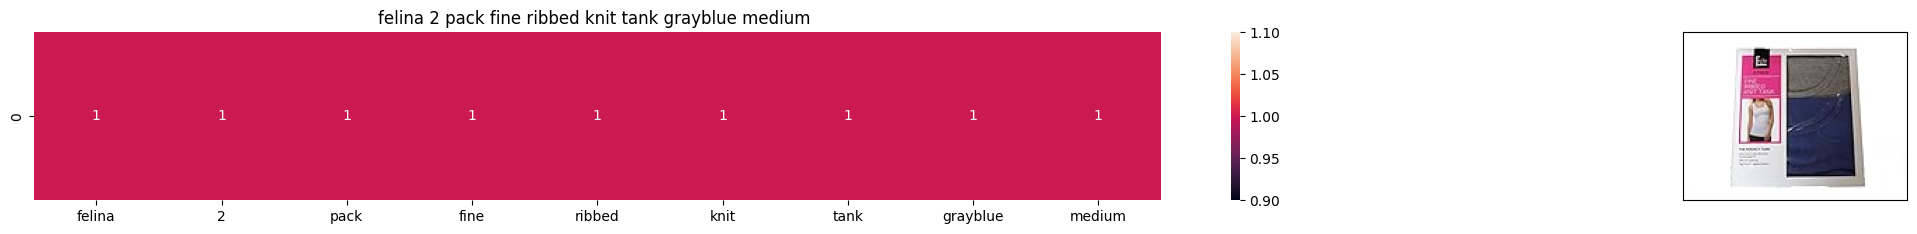

ASIN : B0172JIXAK
Brand: Felina
Title: felina 2 pack fine ribbed knit tank grayblue medium 
Euclidean similarity with the query image : 0.0


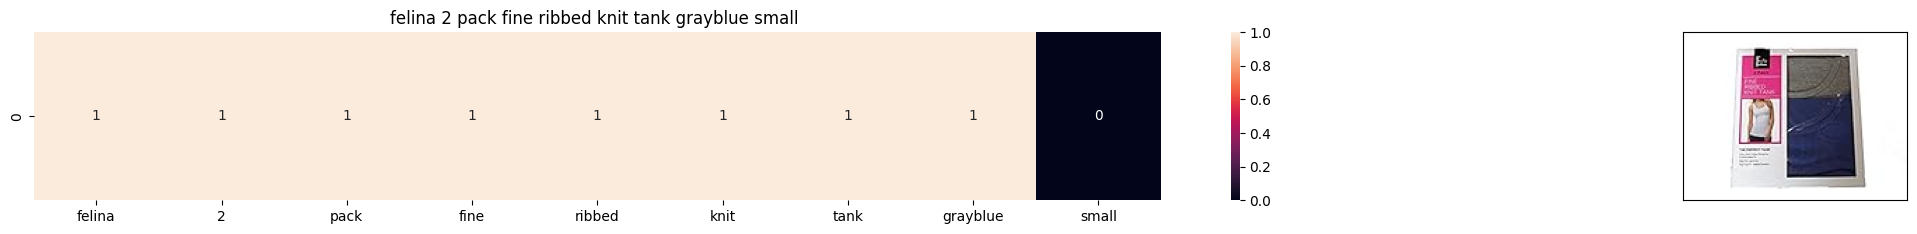

ASIN : B01ACI9VUY
Brand: Felina
Title: felina 2 pack fine ribbed knit tank grayblue small 
Euclidean similarity with the query image : 2.8284271247461903


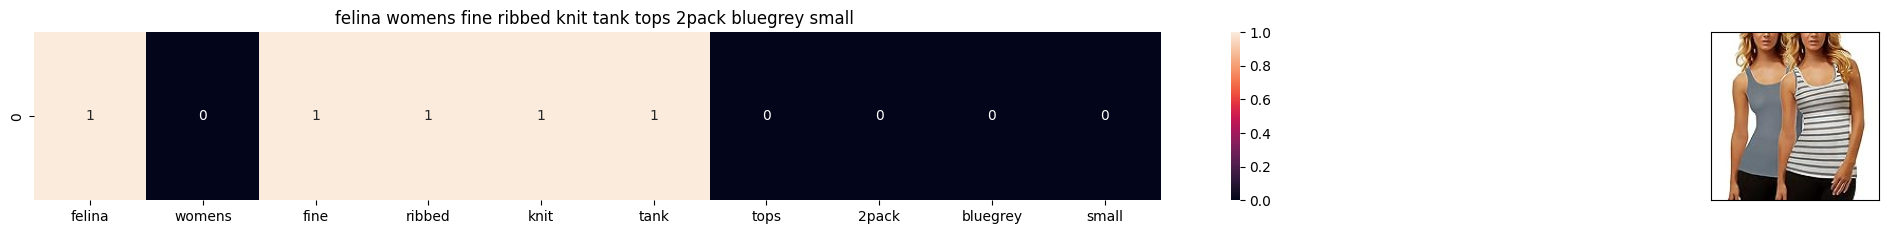

ASIN : B06Y5MBCV5
Brand: Felina
Title: felina womens fine ribbed knit tank tops 2pack bluegrey small 
Euclidean similarity with the query image : 2.8284271247461903


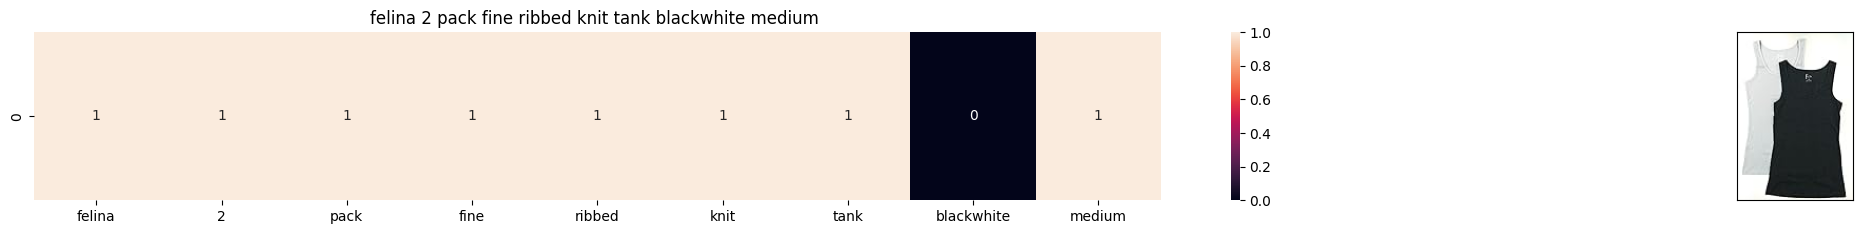

ASIN : B0172HUQ7A
Brand: Felina
Title: felina 2 pack fine ribbed knit tank blackwhite medium 
Euclidean similarity with the query image : 3.414213562373095


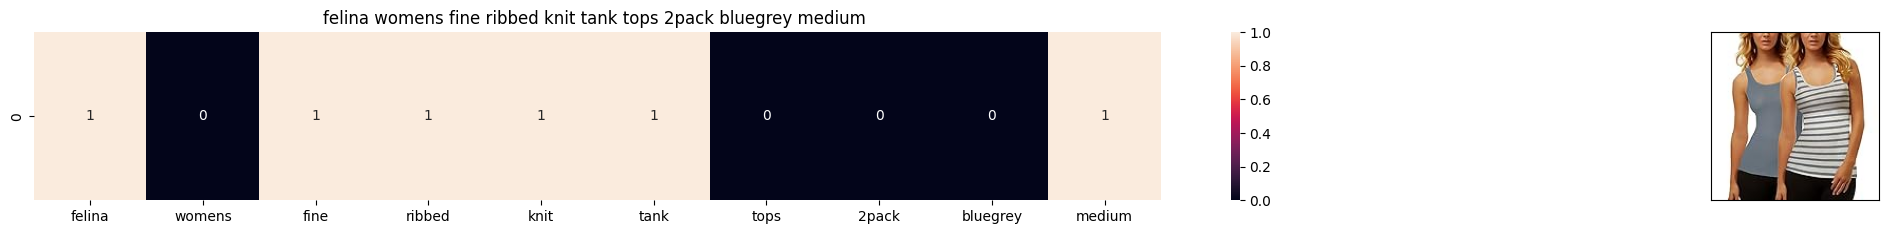

ASIN : B01LBNP8SS
Brand: Felina
Title: felina womens fine ribbed knit tank tops 2pack bluegrey medium 
Euclidean similarity with the query image : 3.449489742783178


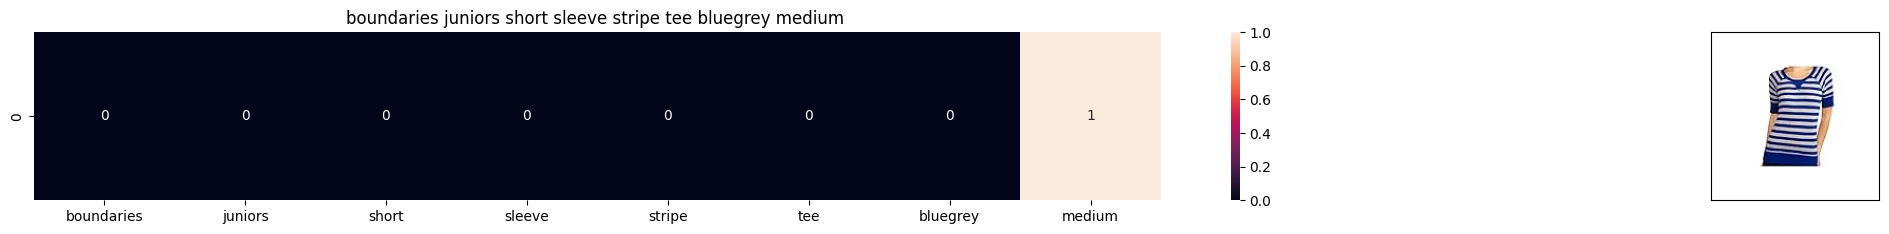

ASIN : B01MRK36V7
Brand: No Boundaries
Title: boundaries juniors short sleeve stripe tee bluegrey medium 
Euclidean similarity with the query image : 3.7416573867739413
Average euclidean distance is  2.710369156903766


In [177]:
print('Getting the similar items for document id and number of items')
bag_of_words_model(56,6)

## KNN based similarity

In [178]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

In [179]:
df.columns

Index(['id', 'asin', 'brand', 'color', 'medium_image_url', 'product_type_name',
       'title', 'formatted_price'],
      dtype='object')

In [180]:
sparse_matrix_products = df[["color","brand","product_type_name","formatted_price"]]

In [181]:
sparse_matrix_products["normalized_price"]=(sparse_matrix_products["formatted_price"]-sparse_matrix_products["formatted_price"].min())/(sparse_matrix_products["formatted_price"].max())

In [182]:
sparse_matrix_products["normalized_price"].describe()

count    19790.000000
mean         0.033758
std          0.046198
min          0.000000
25%          0.012040
50%          0.020040
75%          0.035166
max          0.999990
Name: normalized_price, dtype: float64

In [183]:
sparse_matrix_products.drop("formatted_price", axis=1, inplace=True)

In [184]:
sparse_matrix_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19790 entries, 0 to 19789
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   color              19790 non-null  object 
 1   brand              19790 non-null  object 
 2   product_type_name  19790 non-null  object 
 3   normalized_price   19790 non-null  float64
dtypes: float64(1), object(3)
memory usage: 618.6+ KB


In [185]:
sparse_matrix_products = pd.get_dummies(sparse_matrix_products)

In [186]:
model = NearestNeighbors(n_neighbors=15, metric='cosine', algorithm='brute', n_jobs=-1)
model.fit(sparse_matrix_products)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=15)

In [188]:
import pickle
with open('Fashion/knnpickle_file', 'wb') as handle: 
  pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [189]:
with open('Fashion/knnpickle_file', 'rb') as handle:
    loaded_model = pickle.load(handle)
#distances, indices = loaded_model.kneighbors(sparse_matrix_products.iloc[query_index,:].values.reshape(1,-1))

In [190]:
query_index = np.random.choice(df.shape[0])
distances, indices = loaded_model.kneighbors(sparse_matrix_products.iloc[query_index,:].values.reshape(1,-1))

In [191]:
print(len(distances.flatten()))
M=[]
D=[]
for i in range(0,10):
  if i==0:
    print("Recommendation for {0}:\n".format(sparse_matrix_products.index[query_index]))
  else:
    M.append(sparse_matrix_products.index[indices.flatten()[i]])
    D.append(distances.flatten()[i])
    print("{0}: {1}, with distance of {2}".format(i,sparse_matrix_products.index[indices.flatten()[i]], distances.flatten()[i]))

15
Recommendation for 15039:

1: 6804, with distance of 0.3324604507647283
2: 5836, with distance of 0.3324617825586138
3: 12235, with distance of 0.3324617903544044
4: 14061, with distance of 0.33246624616456655
5: 1860, with distance of 0.3324666962794749
6: 4130, with distance of 0.3324666962794749
7: 394, with distance of 0.33246848020109276
8: 12146, with distance of 0.3324907492612187
9: 14718, with distance of 0.3325071475335284


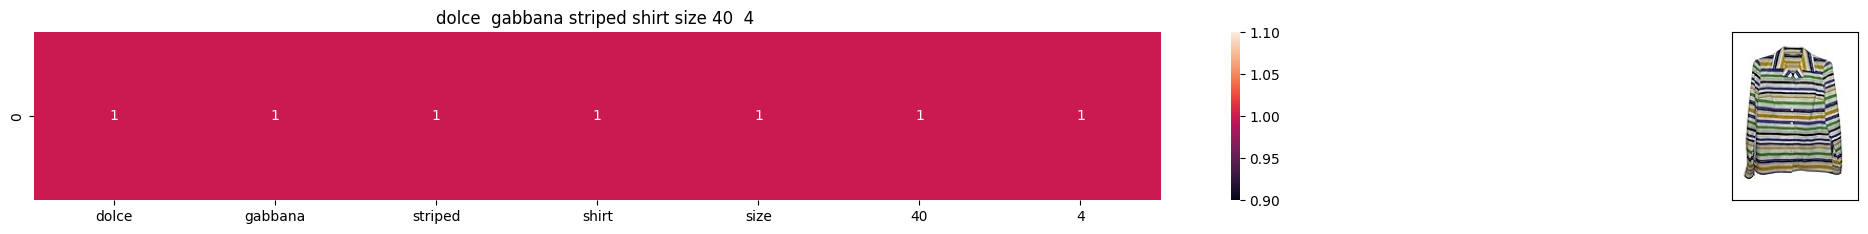

ASIN : B01J4HKNJW
Brand: Dolce & Gabbana
Color: violet
Price: 119.0
Title: dolce  gabbana striped shirt size 40  4 
The distance is : 0.3324604507647283


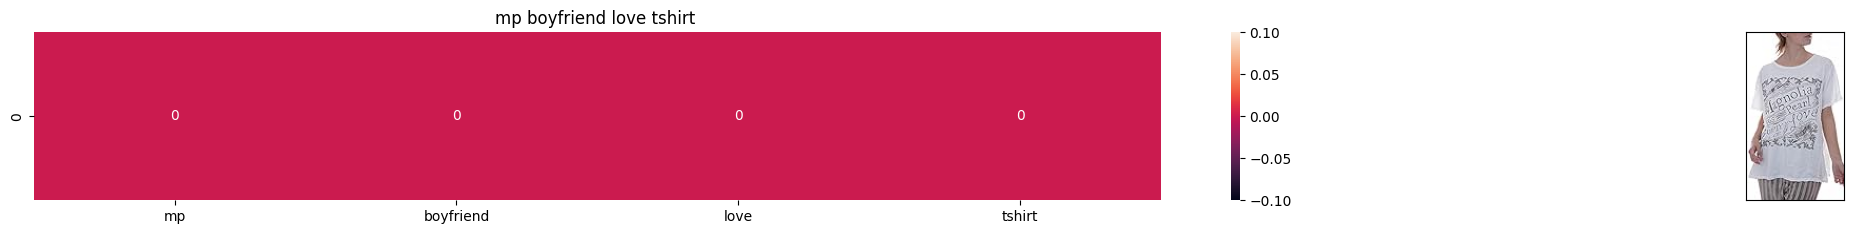

ASIN : B074G4LJV4
Brand: Magnolia Pearl
Color: violet
Price: 115.0
Title: mp boyfriend love tshirt 
The distance is : 0.3324617825586138


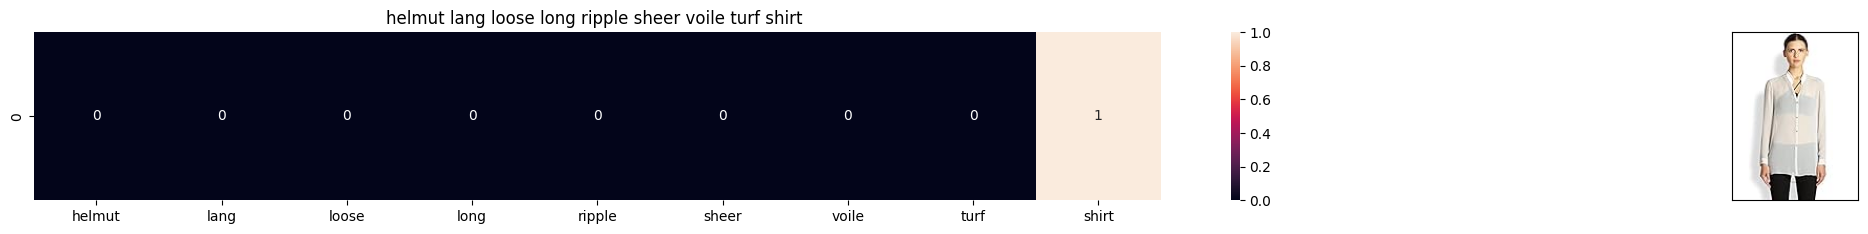

ASIN : B01H348M00
Brand: Helmut Lang
Color: violet
Price: 114.99
Title: helmut lang loose long ripple sheer voile turf shirt 
The distance is : 0.3324617903544044


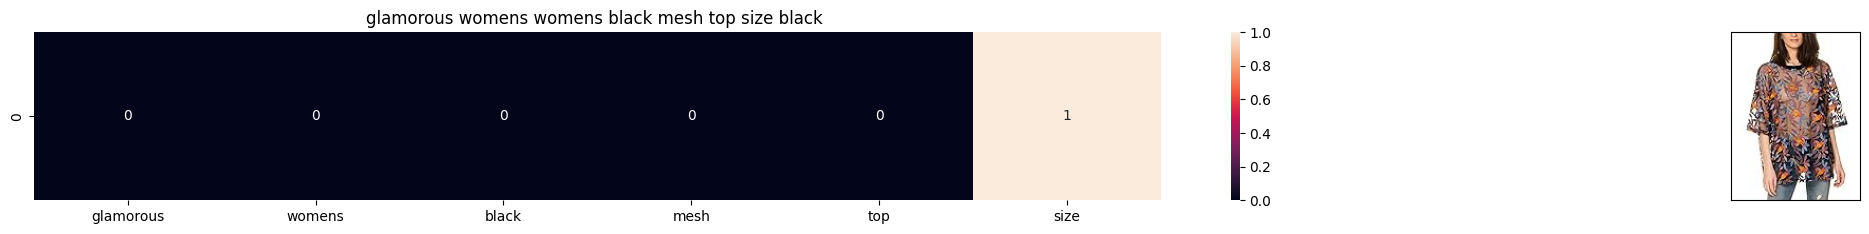

ASIN : B06Y3S5H62
Brand: Glamorous
Color: violet
Price: 125.73
Title: glamorous womens womens black mesh top size black 
The distance is : 0.33246624616456655


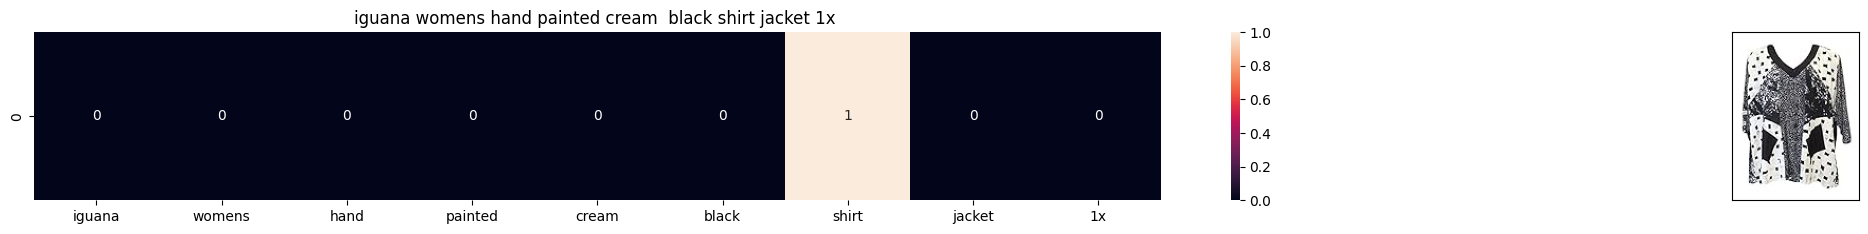

ASIN : B00W5X2I6Y
Brand: Iguana
Color: violet
Price: 110.99
Title: iguana womens hand painted cream  black shirt jacket 1x 
The distance is : 0.3324666962794749


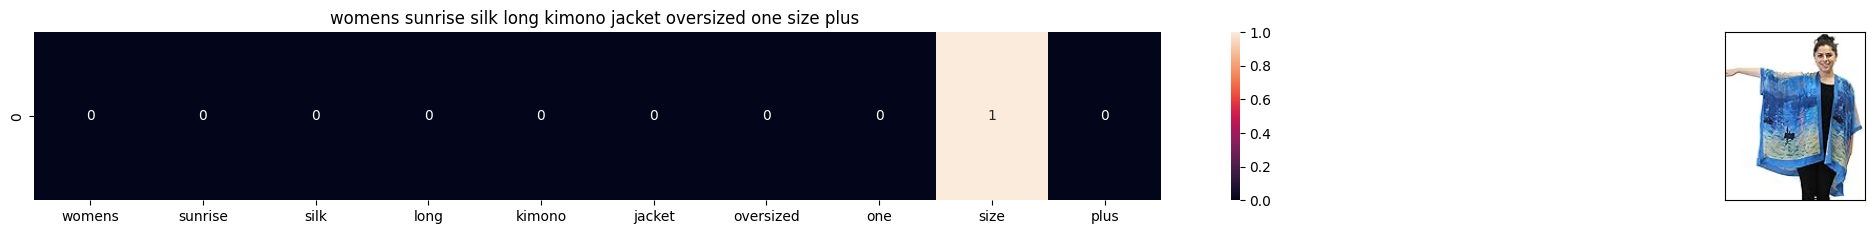

ASIN : B01HIT5PZ0
Brand: Cocoon House
Color: violet
Price: 110.99
Title: womens sunrise silk long kimono jacket oversized one size plus 
The distance is : 0.3324666962794749


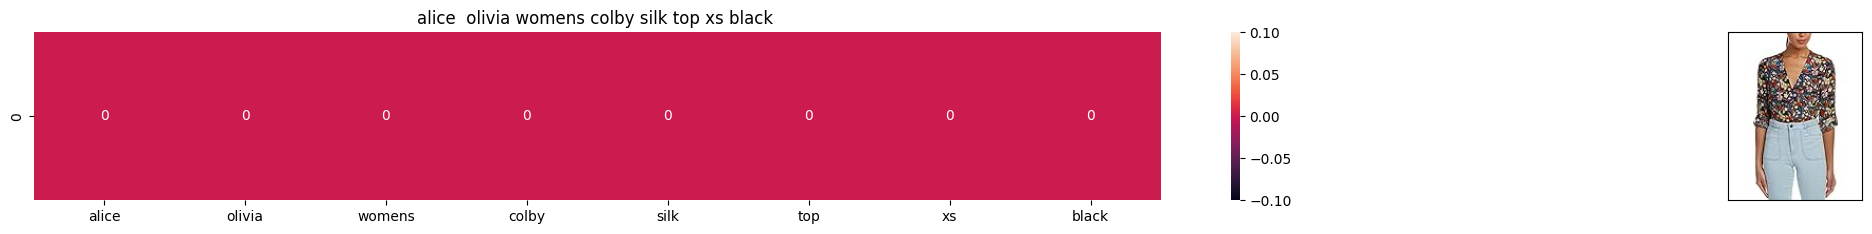

ASIN : B072MH6K7D
Brand: alice + olivia
Color: violet
Price: 109.99
Title: alice  olivia womens colby silk top xs black 
The distance is : 0.33246848020109276


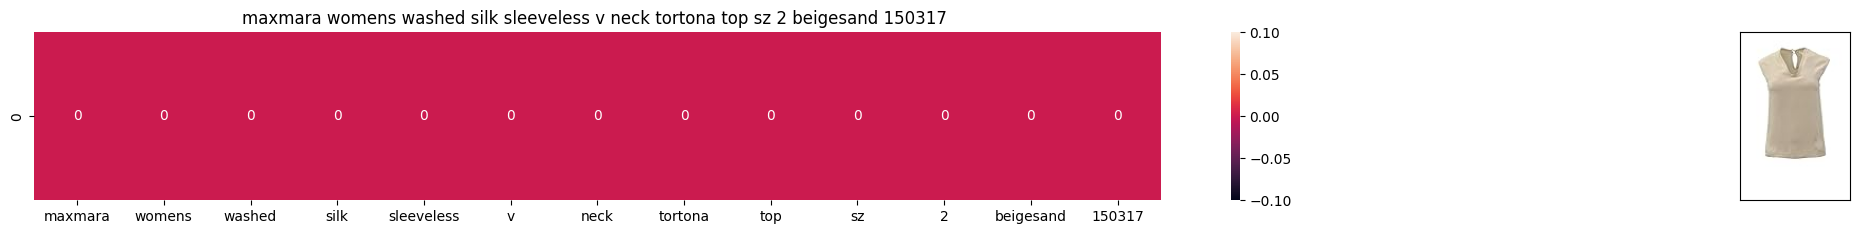

ASIN : B01H28M1PY
Brand: S' MAXMARA
Color: violet
Price: 102.0
Title: maxmara womens washed silk sleeveless v neck tortona top sz 2 beigesand 150317 
The distance is : 0.3324907492612187


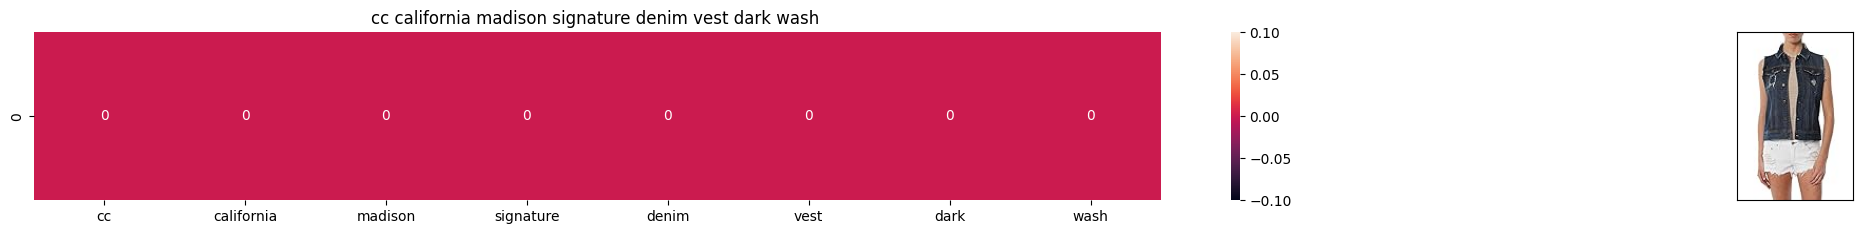

ASIN : B071CHK8M9
Brand: C&C California
Color: violet
Price: 139.0
Title: cc california madison signature denim vest dark wash 
The distance is : 0.3325071475335284


In [192]:
for i in range(0,len(M)):
    get_result(M[i],df['title'].loc[M[0]], df['title'].loc[M[i]], df['medium_image_url'].loc[M[i]], 'bag_of_words')
    print('ASIN :',df['asin'].loc[M[i]])
    print ('Brand:', df['brand'].loc[M[i]])
    print ('Color:', df['color'].loc[M[i]])
    print ('Price:', df['formatted_price'].loc[M[i]])
    print ('Title:', df['title'].loc[M[i]])
    print ("The distance is :", D[i])
    print('='*60)